### Created on 2025
### @author: S.W

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
import random
from collections import Counter
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

### Seq2Seq 모델이란?
- 정의: 입력 시퀀스를 받아서 출력 시퀀스를 생성하는 모델
- 구조: Encoder(인코더) + Decoder(디코더)
- 예시: 번역, 요약, 챗봇, 이미지 캡셔닝 등

기본 구조:
- 입력: '안녕하세요' → [Encoder] → 고정 크기 벡터 → [Decoder] → 'Hello'

이번 예제: 간단한 영어 → 한글 번역
- 'I love you' → '나는 너를 사랑해'
- 'How are you' → '어떻게 지내'

#### 1. 간단한 영어-한글 번역 데이터 준비

In [2]:
print("\n📊 번역 데이터 준비")
print("=" * 30)

# 간단한 영어-한글 문장 쌍 (초심자용)
translation_pairs = [
    # 인사
    ("hello", "안녕"),
    ("good morning", "좋은 아침"),
    ("good night", "좋은 밤"),
    ("how are you", "어떻게 지내"),
    ("nice to meet you", "만나서 반가워"),
    
    # 기본 표현
    ("i love you", "나는 너를 사랑해"),
    ("thank you", "고마워"),
    ("i am sorry", "미안해"),
    ("you are welcome", "천만에"),
    ("see you later", "나중에 봐"),
    
    # 간단한 문장
    ("i am happy", "나는 행복해"),
    ("you are kind", "너는 친절해"),
    ("this is good", "이것은 좋아"),
    ("that is bad", "그것은 나빠"),
    ("i like this", "나는 이것을 좋아해"),
    
    # 질문
    ("what is this", "이것은 무엇"),
    ("where are you", "너는 어디에"),
    ("when do you come", "언제 와"),
    ("why are you sad", "왜 슬퍼"),
    ("who is that", "그것은 누구"),
    
    # 더 많은 예제 (패턴 학습용)
    ("i eat food", "나는 음식을 먹어"),
    ("you drink water", "너는 물을 마셔"),
    ("we go home", "우리는 집에 가"),
    ("they are friends", "그들은 친구야"),
    ("he is teacher", "그는 선생님이야"),
    ("she is student", "그녀는 학생이야"),
    ("today is monday", "오늘은 월요일"),
    ("tomorrow is tuesday", "내일은 화요일"),
    ("i study english", "나는 영어를 공부해"),
    ("you speak korean", "너는 한국어를 말해"),
] * 3  # 데이터 증강을 위해 3배 복사

print(f"💾 전체 번역 쌍: {len(translation_pairs)}개")
print("📝 샘플 데이터:")
for i in range(5):
    eng, kor = translation_pairs[i]
    print(f"   영어: '{eng}' → 한글: '{kor}'")


📊 번역 데이터 준비
💾 전체 번역 쌍: 90개
📝 샘플 데이터:
   영어: 'hello' → 한글: '안녕'
   영어: 'good morning' → 한글: '좋은 아침'
   영어: 'good night' → 한글: '좋은 밤'
   영어: 'how are you' → 한글: '어떻게 지내'
   영어: 'nice to meet you' → 한글: '만나서 반가워'


#### 2. 텍스트 전처리 (아주 간단하게)

In [3]:
print("\n🔧 텍스트 전처리")
print("=" * 25)

# 영어 전처리 (소문자화, 특수기호 제거)
def preprocess_english(text):
    # 소문자로 변환
    text = text.lower()
    # 알파벳과 공백만 남기기
    text = re.sub(r'[^a-z\s]', '', text)
    # 연속된 공백 제거
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 한글 전처리 (간단하게)
def preprocess_korean(text):
    # 한글과 공백만 남기기
    text = re.sub(r'[^가-힣\s]', '', text)
    # 연속된 공백 제거
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 전처리 적용
preprocessed_pairs = []
for eng, kor in translation_pairs:
    eng_clean = preprocess_english(eng)
    kor_clean = preprocess_korean(kor)
    if eng_clean and kor_clean:  # 빈 문자열이 아닌 경우만
        preprocessed_pairs.append((eng_clean, kor_clean))

print(f"✅ 전처리 완료: {len(preprocessed_pairs)}개 문장 쌍")
print("🔍 전처리 결과:")
for i in range(3):
    eng, kor = preprocessed_pairs[i]
    print(f"   영어: '{eng}' → 한글: '{kor}'")


🔧 텍스트 전처리
✅ 전처리 완료: 90개 문장 쌍
🔍 전처리 결과:
   영어: 'hello' → 한글: '안녕'
   영어: 'good morning' → 한글: '좋은 아침'
   영어: 'good night' → 한글: '좋은 밤'


#### 3. 어휘집(Vocabulary) 구축

In [4]:
# 특수 토큰 정의
SOS_TOKEN = '<SOS>'  # Start of Sequence (문장 시작)
EOS_TOKEN = '<EOS>'  # End of Sequence (문장 끝)  
PAD_TOKEN = '<PAD>'  # Padding (빈 공간 채우기)
UNK_TOKEN = '<UNK>'  # Unknown (모르는 단어)

print("🔤 특수 토큰:")
print(f"   {SOS_TOKEN}: 문장 시작을 알리는 토큰")
print(f"   {EOS_TOKEN}: 문장 끝을 알리는 토큰")
print(f"   {PAD_TOKEN}: 길이를 맞추기 위한 패딩")
print(f"   {UNK_TOKEN}: 모르는 단어")

🔤 특수 토큰:
   <SOS>: 문장 시작을 알리는 토큰
   <EOS>: 문장 끝을 알리는 토큰
   <PAD>: 길이를 맞추기 위한 패딩
   <UNK>: 모르는 단어


In [5]:
# 영어 어휘집 만들기
english_words = []
for eng, _ in preprocessed_pairs:
    english_words.extend(eng.split())

english_word_counts = Counter(english_words)
print(f"\n🔤 영어 단어 종류: {len(english_word_counts)}개")
print("📊 가장 자주 나오는 영어 단어:")
for word, count in english_word_counts.most_common(10):
    print(f"   '{word}': {count}번")


🔤 영어 단어 종류: 54개
📊 가장 자주 나오는 영어 단어:
   'you': 36번
   'is': 24번
   'are': 18번
   'i': 18번
   'good': 9번
   'this': 9번
   'am': 6번
   'that': 6번
   'hello': 3번
   'morning': 3번


In [6]:
# 영어 단어 → 숫자 매핑
eng_word2idx = {PAD_TOKEN: 0, UNK_TOKEN: 1, SOS_TOKEN: 2, EOS_TOKEN: 3}
eng_idx2word = {0: PAD_TOKEN, 1: UNK_TOKEN, 2: SOS_TOKEN, 3: EOS_TOKEN}

idx = 4
for word in english_word_counts:
    eng_word2idx[word] = idx
    eng_idx2word[idx] = word
    idx += 1

eng_vocab_size = len(eng_word2idx)
print(f"✅ 영어 어휘집 크기: {eng_vocab_size}")

✅ 영어 어휘집 크기: 58


In [7]:
# 한글 어휘집 만들기
korean_words = []
for _, kor in preprocessed_pairs:
    korean_words.extend(kor.split())

korean_word_counts = Counter(korean_words)
print(f"\n🔤 한글 단어 종류: {len(korean_word_counts)}개")
print("📊 가장 자주 나오는 한글 단어:")
for word, count in korean_word_counts.most_common(10):
    print(f"   '{word}': {count}번")


🔤 한글 단어 종류: 53개
📊 가장 자주 나오는 한글 단어:
   '나는': 15번
   '너는': 12번
   '좋은': 6번
   '이것은': 6번
   '그것은': 6번
   '안녕': 3번
   '아침': 3번
   '밤': 3번
   '어떻게': 3번
   '지내': 3번


In [8]:
# 한글 단어 → 숫자 매핑
kor_word2idx = {PAD_TOKEN: 0, UNK_TOKEN: 1, SOS_TOKEN: 2, EOS_TOKEN: 3}
kor_idx2word = {0: PAD_TOKEN, 1: UNK_TOKEN, 2: SOS_TOKEN, 3: EOS_TOKEN}

idx = 4
for word in korean_word_counts:
    kor_word2idx[word] = idx
    kor_idx2word[idx] = word
    idx += 1

kor_vocab_size = len(kor_word2idx)
print(f"✅ 한글 어휘집 크기: {kor_vocab_size}")

✅ 한글 어휘집 크기: 57


#### 4. 문장을 숫자 시퀀스로 변환

In [9]:
# 영어 문장을 숫자로 변환
def english_to_sequence(sentence):
    words = sentence.split()
    sequence = [eng_word2idx.get(word, 1) for word in words]  # 1 = UNK
    sequence.append(3)  # EOS 토큰 추가 (3 = EOS)
    return sequence

# 한글 문장을 숫자로 변환 (SOS 토큰 포함)
def korean_to_sequence(sentence):
    words = sentence.split()
    sequence = [2]  # SOS 토큰으로 시작 (2 = SOS)
    sequence.extend([kor_word2idx.get(word, 1) for word in words])  # 1 = UNK
    sequence.append(3)  # EOS 토큰 추가 (3 = EOS)
    return sequence

# 변환 예시
sample_eng, sample_kor = preprocessed_pairs[0]
eng_seq = english_to_sequence(sample_eng)
kor_seq = korean_to_sequence(sample_kor)

print("🔍 변환 예시:")
print(f"   영어: '{sample_eng}' → {eng_seq}")
print(f"   한글: '{sample_kor}' → {kor_seq}")
print()
print("🔍 숫자의 의미:")
for i, num in enumerate(eng_seq):
    word = eng_idx2word[num]
    print(f"   영어 {num} → '{word}'")
print()
for i, num in enumerate(kor_seq):
    word = kor_idx2word[num]
    print(f"   한글 {num} → '{word}'")

🔍 변환 예시:
   영어: 'hello' → [4, 3]
   한글: '안녕' → [2, 4, 3]

🔍 숫자의 의미:
   영어 4 → 'hello'
   영어 3 → '<EOS>'

   한글 2 → '<SOS>'
   한글 4 → '안녕'
   한글 3 → '<EOS>'


In [10]:
# 모든 문장 쌍을 숫자로 변환
input_sequences = []  # 영어 (Encoder 입력)
target_sequences = []  # 한글 (Decoder 타겟)

for eng, kor in preprocessed_pairs:
    eng_seq = english_to_sequence(eng)
    kor_seq = korean_to_sequence(kor)
    
    input_sequences.append(eng_seq)
    target_sequences.append(kor_seq)

print(f"총 {len(input_sequences)}개 문장 쌍을 숫자로 변환 완료")

총 90개 문장 쌍을 숫자로 변환 완료


#### 5. 패딩 (길이 맞추기)

In [11]:
# 최대 길이 계산
max_eng_len = max(len(seq) for seq in input_sequences)
max_kor_len = max(len(seq) for seq in target_sequences)

print(f"📊 영어 문장 최대 길이: {max_eng_len}")
print(f"📊 한글 문장 최대 길이: {max_kor_len}")

📊 영어 문장 최대 길이: 5
📊 한글 문장 최대 길이: 5


In [12]:
# 패딩 적용 (짧은 문장에 0을 추가하여 길이 맞추기)
def pad_sequence(sequence, max_length):
    if len(sequence) >= max_length:
        return sequence[:max_length]  # 너무 길면 자르기
    else:
        return sequence + [0] * (max_length - len(sequence))  # 0으로 패딩

# 모든 시퀀스에 패딩 적용
padded_input_sequences = []
padded_target_sequences = []

for seq in input_sequences:
    padded_input_sequences.append(pad_sequence(seq, max_eng_len))

for seq in target_sequences:
    padded_target_sequences.append(pad_sequence(seq, max_kor_len))

print("🔍 패딩 예시 (첫 번째 문장):")
print(f"   영어 원본: {input_sequences[0]}")
print(f"   영어 패딩: {padded_input_sequences[0]}")
print(f"   한글 원본: {target_sequences[0]}")
print(f"   한글 패딩: {padded_target_sequences[0]}")

print(f"\n✅ 패딩 완료! 모든 영어 문장: {max_eng_len}자리, 한글 문장: {max_kor_len}자리")

🔍 패딩 예시 (첫 번째 문장):
   영어 원본: [4, 3]
   영어 패딩: [4, 3, 0, 0, 0]
   한글 원본: [2, 4, 3]
   한글 패딩: [2, 4, 3, 0, 0]

✅ 패딩 완료! 모든 영어 문장: 5자리, 한글 문장: 5자리


#### 6. PyTorch 데이터셋 만들기

In [13]:
# 리스트를 PyTorch 텐서로 변환
input_tensor = torch.tensor(padded_input_sequences, dtype=torch.long)
target_tensor = torch.tensor(padded_target_sequences, dtype=torch.long)

print(f"📊 입력 텐서 크기: {input_tensor.shape}")
print(f"📊 타겟 텐서 크기: {target_tensor.shape}")
print(f"   → {input_tensor.shape[0]}개 문장, 영어 최대 {input_tensor.shape[1]}단어")
print(f"   → {target_tensor.shape[0]}개 문장, 한글 최대 {target_tensor.shape[1]}단어")

📊 입력 텐서 크기: torch.Size([90, 5])
📊 타겟 텐서 크기: torch.Size([90, 5])
   → 90개 문장, 영어 최대 5단어
   → 90개 문장, 한글 최대 5단어


In [14]:
# 데이터셋 클래스 정의
class TranslationDataset(Dataset):
    def __init__(self, input_tensor, target_tensor):
        self.input_tensor = input_tensor
        self.target_tensor = target_tensor
    
    def __len__(self):
        return len(self.input_tensor)
    
    def __getitem__(self, idx):
        return self.input_tensor[idx], self.target_tensor[idx]

# 훈련/테스트 데이터 분할
train_size = int(0.8 * len(input_tensor))
test_size = len(input_tensor) - train_size

train_input = input_tensor[:train_size]
train_target = target_tensor[:train_size]
test_input = input_tensor[train_size:]
test_target = target_tensor[train_size:]

train_dataset = TranslationDataset(train_input, train_target)
test_dataset = TranslationDataset(test_input, test_target)

print(f"🔨 훈련 데이터: {len(train_dataset)}개")
print(f"🔨 테스트 데이터: {len(test_dataset)}개")

# 데이터로더 생성
batch_size = 8  # 작은 배치 크기 (초심자용)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"✅ 배치 크기: {batch_size}")

🔨 훈련 데이터: 72개
🔨 테스트 데이터: 18개
✅ 배치 크기: 8


#### 7. Seq2Seq 모델 구조

Seq2Seq = Encoder + Decoder
- Encoder: 영어 문장을 고정 크기 벡터로 압축
- Decoder: 압축된 벡터에서 한글 문장을 생성

In [15]:
# 1단계: Encoder 정의
class Encoder(nn.Module):
    """
    입력: 영어 문장
    출력: 문장의 의미를 담은 벡터
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super(Encoder, self).__init__()
        
        # 단어를 벡터로 변환하는 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # LSTM으로 문장의 의미를 파악
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                           batch_first=True, bidirectional=False)
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
    
    def forward(self, input_seq):
        # 1. 입력 단어들을 벡터로 변환
        embedded = self.embedding(input_seq)  # (배치, 시퀀스길이, 임베딩차원)
        
        # 2. LSTM으로 순차적으로 처리
        output, (hidden, cell) = self.lstm(embedded)
        
        # 3. 마지막 은닉 상태가 문장의 의미를 담고 있음
        return hidden, cell


# 2단계: Decoder 정의  
class Decoder(nn.Module):
    """
    입력: 이전 단어 + 은닉상태
    출력: 다음 단어 확률
    """
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super(Decoder, self).__init__()
        
        # 단어를 벡터로 변환하는 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # LSTM으로 한 단어씩 생성
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers,
                           batch_first=True, bidirectional=False)
        
        # 최종 단어 확률을 계산하는 레이어
        self.output_projection = nn.Linear(hidden_dim, vocab_size)
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
    
    def forward(self, input_token, hidden, cell):
        # 1. 입력 토큰을 벡터로 변환
        embedded = self.embedding(input_token)  # (배치, 1, 임베딩차원)
        
        # 2. LSTM으로 다음 단어 예측
        output, (new_hidden, new_cell) = self.lstm(embedded, (hidden, cell))
        
        # 3. 단어 확률 계산
        prediction = self.output_projection(output)  # (배치, 1, 어휘크기)
        
        return prediction, new_hidden, new_cell


# 3단계: Seq2Seq 모델 (Encoder + Decoder)
class Seq2Seq(nn.Module):
    """
    입력: 영어 문장 → 출력: 한글 문장 확률
    """
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
    
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        """
        src: 영어 문장 (배치, 영어길이)
        trg: 한글 문장 (배치, 한글길이)  
        teacher_forcing_ratio: Teacher Forcing 비율
        """
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_projection.out_features
        
        # 출력을 저장할 텐서
        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        
        # 1. Encoder로 영어 문장을 이해
        hidden, cell = self.encoder(src)
        
        # 2. Decoder의 첫 입력은 <SOS> 토큰
        input_token = trg[:, 0].unsqueeze(1)  # 첫 번째 토큰 (<SOS>)
        
        # 3. 한 단어씩 생성
        for t in range(1, trg_len):
            # Decoder로 다음 단어 예측
            output, hidden, cell = self.decoder(input_token, hidden, cell)
            outputs[:, t] = output.squeeze(1)
            
            # Teacher Forcing: 때로는 정답을 주고, 때로는 예측을 사용
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(2)  # 가장 확률 높은 단어
            
            input_token = trg[:, t].unsqueeze(1) if teacher_force else top1
        
        return outputs

#### 8. 모델 초기화

In [16]:
# 하이퍼파라미터 설정
embedding_dim = 64    # 단어 벡터 크기 (작게 설정)
hidden_dim = 128      # 은닉 상태 크기
num_layers = 1        # LSTM 레이어 수 (단순하게)
learning_rate = 0.01  # 학습률

print("🎛️ 하이퍼파라미터:")
print(f"   임베딩 차원: {embedding_dim}")
print(f"   은닉 차원: {hidden_dim}")
print(f"   LSTM 레이어: {num_layers}")
print(f"   학습률: {learning_rate}")

🎛️ 하이퍼파라미터:
   임베딩 차원: 64
   은닉 차원: 128
   LSTM 레이어: 1
   학습률: 0.01


In [17]:
# GPU 사용 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ 사용 장치: {device}")

🖥️ 사용 장치: cuda


In [18]:
# Encoder, Decoder 생성
encoder = Encoder(eng_vocab_size, embedding_dim, hidden_dim, num_layers)
decoder = Decoder(kor_vocab_size, embedding_dim, hidden_dim, num_layers)

# Seq2Seq 모델 생성
model = Seq2Seq(encoder, decoder, device).to(device)

# 모델 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())
print(f"🤖 모델 파라미터 수: {total_params:,}개")

# 손실 함수와 옵티마이저
criterion = nn.CrossEntropyLoss(ignore_index=0)  # 패딩은 무시
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("✅ 모델 초기화 완료!")

🤖 모델 파라미터 수: 213,369개
✅ 모델 초기화 완료!


#### 9. 훈련 과정 (Teacher Forcing 설명 포함)

Teacher Forcing이란?
- 훈련 시에 정답을 일부러 알려주는 기법
- 예: '나는' 다음에 '너를'이 올 확률을 높이기 위해 실제 정답 '너를'을 입력으로 사용

In [19]:
# 훈련 기록을 위한 리스트
train_losses = []
epochs = 50  # 에포크 수 (적당히)

print(f"🎯 {epochs} 에포크 동안 훈련합니다...")

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    
    # 배치별로 훈련
    for batch_idx, (input_batch, target_batch) in enumerate(train_loader):
        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)
        
        # 1. 그래디언트 초기화
        optimizer.zero_grad()
        
        # 2. 모델 예측 (Teacher Forcing 비율 70%)
        output = model(input_batch, target_batch, teacher_forcing_ratio=0.7)
        
        # 3. 손실 계산 (첫 번째 토큰 <SOS>는 제외)
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        target = target_batch[:, 1:].reshape(-1)
        
        loss = criterion(output, target)
        
        # 4. 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # 에포크 평균 손실
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    
    # 진행 상황 출력 (5 에포크마다)
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1:2d}/{epochs}: Loss = {avg_loss:.4f}")

🎯 50 에포크 동안 훈련합니다...
Epoch  5/50: Loss = 0.3342
Epoch 10/50: Loss = 0.0149
Epoch 15/50: Loss = 0.0046
Epoch 20/50: Loss = 0.0028
Epoch 25/50: Loss = 0.0020
Epoch 30/50: Loss = 0.0015
Epoch 35/50: Loss = 0.0012
Epoch 40/50: Loss = 0.0009
Epoch 45/50: Loss = 0.0008
Epoch 50/50: Loss = 0.0007


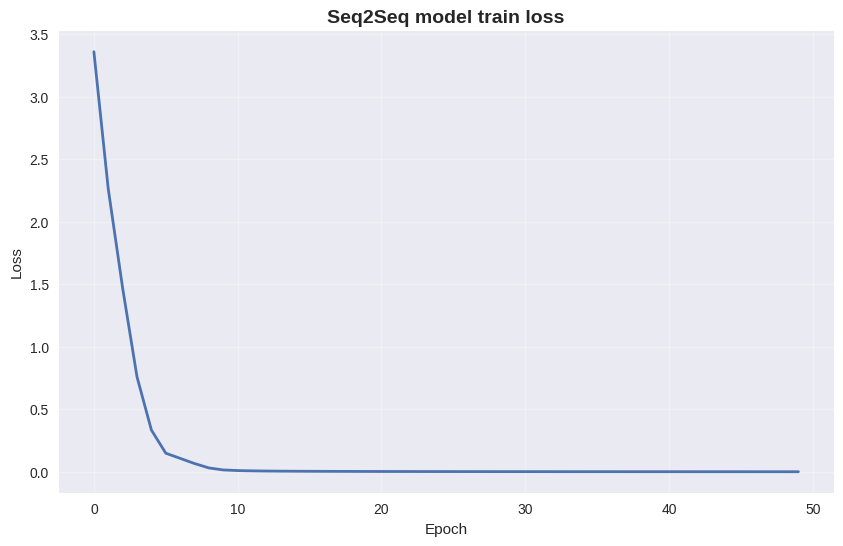

In [20]:
# 훈련 손실 그래프
plt.figure(figsize=(10, 6))
plt.plot(train_losses, linewidth=2)
plt.title('Seq2Seq model train loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.show()

#### 10. 번역 함수 (추론 과정)

추론 과정과 훈련 과정의 차이:
- 훈련: Teacher Forcing으로 정답을 알려줌
- 추론: 이전 예측을 다음 입력으로 사용 (실제 번역)

In [21]:
def translate_sentence(sentence, model, max_length=20):
    """영어 문장을 한글로 번역하는 함수"""
    model.eval()  # 평가 모드
    
    with torch.no_grad():  # 그래디언트 계산 안함 (추론 모드)
        # 1. 입력 문장 전처리
        sentence = preprocess_english(sentence)
        tokens = sentence.split()
        
        # 2. 숫자 시퀀스로 변환
        sequence = [eng_word2idx.get(token, 1) for token in tokens]  # 1 = UNK
        sequence.append(3)  # EOS 토큰 추가
        
        # 3. 패딩 적용
        sequence = pad_sequence(sequence, max_eng_len)
        
        # 4. 텐서로 변환 (배치 차원 추가)
        src_tensor = torch.tensor([sequence], dtype=torch.long).to(device)
        
        # 5. Encoder로 영어 문장 이해
        hidden, cell = model.encoder(src_tensor)
        
        # 6. Decoder로 한글 문장 생성
        outputs = []
        input_token = torch.tensor([[2]], dtype=torch.long).to(device)  # SOS 토큰
        
        for _ in range(max_length):
            output, hidden, cell = model.decoder(input_token, hidden, cell)
            predicted_token = output.argmax(dim=-1)
            
            # EOS 토큰이면 종료
            if predicted_token.item() == 3:  # 3 = EOS
                break
            
            outputs.append(predicted_token.item())
            input_token = predicted_token
        
        # 7. 숫자를 한글 단어로 변환
        korean_words = []
        for token_id in outputs:
            if token_id in kor_idx2word and token_id not in [0, 1, 2, 3]:  # 특수토큰 제외
                korean_words.append(kor_idx2word[token_id])
        
        return ' '.join(korean_words) if korean_words else "번역 실패"

print("✅ 번역 함수 구현 완료!")

✅ 번역 함수 구현 완료!


#### 11. 번역 테스트

In [22]:
# 테스트 문장들
test_sentences = [
    "hello",
    "thank you", 
    "i love you",
    "how are you",
    "good morning",
    "i am happy",
    "you are kind",
    "what is this",
    "see you later",
    "nice to meet you"
]

print("🔍 번역 결과:")

for eng_sentence in test_sentences:
    korean_result = translate_sentence(eng_sentence, model)
    print(f"영어: '{eng_sentence}'")
    print(f"번역: '{korean_result}'")
    
    # 정답 찾기 (훈련 데이터에서)
    correct_answer = "정답 없음"
    for train_eng, train_kor in preprocessed_pairs:
        if train_eng == preprocess_english(eng_sentence):
            correct_answer = train_kor
            break
    
    print(f"정답: '{correct_answer}'")
    print("-" * 50)

🔍 번역 결과:
영어: 'hello'
번역: '안녕'
정답: '안녕'
--------------------------------------------------
영어: 'thank you'
번역: '고마워'
정답: '고마워'
--------------------------------------------------
영어: 'i love you'
번역: '나는 너를 사랑해'
정답: '나는 너를 사랑해'
--------------------------------------------------
영어: 'how are you'
번역: '어떻게 지내'
정답: '어떻게 지내'
--------------------------------------------------
영어: 'good morning'
번역: '좋은 아침'
정답: '좋은 아침'
--------------------------------------------------
영어: 'i am happy'
번역: '나는 행복해'
정답: '나는 행복해'
--------------------------------------------------
영어: 'you are kind'
번역: '너는 친절해'
정답: '너는 친절해'
--------------------------------------------------
영어: 'what is this'
번역: '이것은 무엇'
정답: '이것은 무엇'
--------------------------------------------------
영어: 'see you later'
번역: '나중에 봐'
정답: '나중에 봐'
--------------------------------------------------
영어: 'nice to meet you'
번역: '만나서 반가워'
정답: '만나서 반가워'
--------------------------------------------------


#### 12. 새로운 문장 번역 테스트

훈련 데이터에 없는 새로운 문장들로 테스트해보겠습니다:

In [23]:
new_test_sentences = [
    "hello you",          # "안녕" + "너는" = ?
    "i am good",          # "나는" + "좋아" = ?
    "thank you very",     # 일부만 알고 있는 경우
    "you love me",        # 단어 순서가 다른 경우
    "good you are"        # 문법이 다른 경우
]

print("🔍 새로운 문장 번역 결과:")
print("-" * 40)

for sentence in new_test_sentences:
    result = translate_sentence(sentence, model)
    print(f"입력: '{sentence}' → 번역: '{result}'")

🔍 새로운 문장 번역 결과:
----------------------------------------
입력: 'hello you' → 번역: '고마워'
입력: 'i am good' → 번역: '나는 행복해'
입력: 'thank you very' → 번역: '고마워'
입력: 'you love me' → 번역: '나는 너를 사랑해'
입력: 'good you are' → 번역: '너는 친절해'


#### 14. 모델 성능 분석

In [24]:
# 정확도 계산 (완전 일치)
correct_translations = 0
total_tests = len(test_sentences)

for eng_sentence in test_sentences:
    predicted = translate_sentence(eng_sentence, model)
    
    # 정답 찾기
    for train_eng, train_kor in preprocessed_pairs:
        if train_eng == preprocess_english(eng_sentence):
            if predicted.strip() == train_kor.strip():
                correct_translations += 1
            break

accuracy = correct_translations / total_tests * 100
print(f"🎯 번역 정확도: {accuracy:.1f}% ({correct_translations}/{total_tests})")

🎯 번역 정확도: 100.0% (10/10)


In [25]:
# 단어별 정확도 계산
word_correct = 0
word_total = 0

for eng_sentence in test_sentences:
    predicted = translate_sentence(eng_sentence, model)
    predicted_words = predicted.split()
    
    # 정답 찾기
    for train_eng, train_kor in preprocessed_pairs:
        if train_eng == preprocess_english(eng_sentence):
            correct_words = train_kor.split()
            
            # 단어별 비교
            min_len = min(len(predicted_words), len(correct_words))
            for i in range(min_len):
                word_total += 1
                if predicted_words[i] == correct_words[i]:
                    word_correct += 1
            break

word_accuracy = word_correct / word_total * 100 if word_total > 0 else 0
print(f"🔤 단어별 정확도: {word_accuracy:.1f}% ({word_correct}/{word_total})")

🔤 단어별 정확도: 100.0% (19/19)
